# Disease Type Classifier Evaluation

- BME 230A class project winter 2019
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=SimpleModel.ipynb)

A comparison of known cancer causing genes with those identified by a classifier trained on gene expression data.


## Overview:
Typically data science projects develop models de novo. You start by mining an unknown data set. Your objective is to find structure in the data and create a data product. That is to say some sort of predictive model. It is important to understand the difference between a data product and a model. Models are of limited use. Often they may help you gain a better understanding of the relationships inherent in your data. A model is often considered good based on it's accuracy alone. Models are steps on the path to developing true data products. 

By contrast data products are models that can be deployed at scale. Rarely is accuracy alone sufficient to decide if a model is deployable. In addiction to accuracy, most often data products must be explainable and generalize well.

For data products to be deployable we must have confidence that our model generalize to the true targeted population. In the case of the Xena data set, we need not only patients that are sick and may or may not have cancer but also to health individuals. We also need to account for demographic bias in the training data set.  Data products related to human behavior, for example recommender systems, or natural language tasks, must have mechanisms to identify population drift and processes for retrain.

Explainability is often over looked when evaluating the deployability of a data product. Sometimes it is not required. For example consider a bad movie recommender. The viewer is not going to be harmed in anyway. For most data product the cost of false positives or negatives is high. For example consider a tumor/normal classifier or a model used to set insurance premiums. The new EU General Data Protection Regulation requires explainability for models with potential high mis-classification costs. It also seems unlike the the FDA will approve models that are not explainable. 

Lack of explainablity often limits the use of of Neural Networks. Fortunately neural network models based on Xena data set may be explainable. One approach for gaining insight into the workings of a trained model is to make predictions with hand crafter example and explore how these example activate the various layers of the neural network. [Andrej Karpath](https://cs.stanford.edu/people/karpathy/) used a similar approach to identify what kinds of images cause the filters of a convolutional neural network to activate.

## Methods:

The input size of our model is 58,581. Each value is a gene expression level. For each feature we make a prediction use a one-hot example. We then group the genes into sets based on the predicted disease type. We would expect the gene groups to correspond to know cancer related genes. Genes identified by the model that are not part of know pathways should be further explored.

## Results:

Figure 1. is a histogram showing the count of genes that individually classified as disease type. To make the analysis easier we select the disease type with the fewest number of genes"

```
disease type with smallest identified gene set:['Pancreatic Adenocarcinoma']
number of genes in set:44
       ['AC079235.1', 'AC087499.9', 'AC090311.1', 'AC231645.1',
       'AL008708.1', 'AL354931.1', 'AL603650.4', 'ARAF', 'ATP6V1D',
       'C14orf93', 'CLK3', 'CNPY3', 'CTC-258N23.3', 'CTD-2132H18.3',
       'CYB5D2', 'FADS2P1', 'FBXW4', 'GOLGB1', 'HMGN1P5', 'KB-1582A10.2',
       'LINC00616', 'LINC01035', 'MED10', 'MON1A', 'NEK3', 'PIN1',
       'RFPL3-AS1_1', 'RNA5SP143', 'RNA5SP366', 'RNA5SP409', 'RNA5SP523',
       'RNA5SP55', 'RNU6-1194P', 'RNU6-204P', 'RNU6-498P',
       'RP11-626I20.3', 'RP11-74J13.9', 'SCARNA4', 'SF3B5', 'SGSM3',
       'SLC35B3', 'SNORA70D', 'STX18', 'SUGT1']
```

<span style="color:red">TODO: figure out how to mine biologic path way data.</span> We need to figure out how to map the gene sets we identify back to the know genes associated with each cancer type

reference:
- [diseaseTypeClassifier.ipynb](diseaseTypeClassifier.ipynb)
- [https://github.com/AEDWIP/BME-230a.git](https://github.com/AEDWIP/BME-230a.git)

In [1]:
from keras.models import load_model

import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import sys

import tensorflow as tf

# fix random seed for reproducibility
theMeaningOfLife = 42

import keras
if "2.1.6" != keras.__version__ :
    emsg = "ERROR keras version {} != 2.1.6, new version can not save and restore models".format(keras.__version__)
    raise ValueError(emsg)

# add path to our local modules
# assume they are in the same directory we launched the juypter server in
# /home/ubuntu/BME-230a
!pwd
localModuleDir = "."
sys.path.append(localModuleDir)

Using TensorFlow backend.


/home/ubuntu/BME-230a


## load model and data

In [2]:
%%time
rootDir = "/bme-230a-ebs"
sourceDataFilePath = "{}/data/tcga_target_gtex.h5".format(rootDir)
print(sourceDataFilePath)
if not os.path.isfile(sourceDataFilePath):
    emsg = "ERROR: {} not found".format(sourceDataFilePath)
    print(emsg)
    print("change rootDir")
    sys.stdout.flush()  # force error message to print
    raise ValueError(emsg)

from loadData import loadCancerDiseaseTypeTidyDataSet

ret = loadCancerDiseaseTypeTidyDataSet(rootDir)
hugoIds, diseaseLabelEncoder, XTrainNumpy, yTrainNumpy, XTestNumpy, yTestNumpy = ret
#XTestNumpy = yTestNumpy = None # clean up memory
ret = None  # clean up memory

/bme-230a-ebs/data/tcga_target_gtex.h5
sourceDataFilePath:/bme-230a-ebs/data/tcga_target_gtex.h5
CPU times: user 1.33 s, sys: 5.29 s, total: 6.62 s
Wall time: 26.2 s


## <span style="color:red"> AEDWIP the data looks suprisingly homogenous</span>
- was there a bug in the original data set prepration ?
- was a bug introduced while creating the tidy data set?
    * maybe sklearn.model_selection.StratifiedShuffleSplit samples with replacement by default?
- signifigant figure?

In [3]:
print(XTrainNumpy[0:10, 0:3])

[[-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]
 [-9.96604119 -9.96581639 -9.96588062]]


In [4]:
modelName="diseaseClassifier"
modelRootDir = "{}/models".format(rootDir)
fullModelPath = "{}/{}.h5".format(modelRootDir, modelName)
diseaseClassifierModel = load_model(fullModelPath)
diseaseClassifierModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 58581)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58581)             234324    
_________________________________________________________________
dense_1 (Dense)              (None, 38)                2226116   
_________________________________________________________________
activation_1 (Activation)    (None, 38)                0         
Total params: 2,460,440
Trainable params: 2,343,278
Non-trainable params: 117,162
_________________________________________________________________


## Identify what disease type a given gene contributes the most to
It is often difficult to understand how neural networks work. One approach for gaining insight is given a trained model make predictions with hand crafted example. Next explore the correspond activation at each layer of the model. [Andrej Karpath](https://cs.stanford.edu/people/karpathy/) used a similar approach to identify what kinds of images cause the filters of a convolutional neural network to activate.

In [5]:
%%time
# find which class a gene maximal activates
def largestActivation(model, m, batchSize):
    '''
    for each featue calculates the disease type the feature makes the largest contribution to
    
    input:
        model:
        m: the number of features
        batchSize
        
    returns:
        numpy array of size (m,1).
        array[i] is the disease value of the gene at position i in the feature set
    '''
    ret = np.zeros((m, 1))
    numBatches, r = divmod(m, batchSize)
    print("m:{} batchSize:{} numBatches:{} r:{}".format(
        m, batchSize, numBatches, r))
    startRowIdx = 0
    batchCount = 0
    while (batchCount < numBatches):
        if batchCount < numBatches:
            bs = batchSize
        else:
            bs = r  # short batch

        # create a feature vector one hot. We only want the activation f
        # value for a single gene
        batch = np.zeros((bs, m))
        for j in range(bs):
            # use a high value
            # when value was 1 all predictions where class 27
            batch[j, startRowIdx + j] = 1000000

        predictions = model.predict(batch)
        predictedValuesTensor = keras.backend.argmax(predictions)

        # use keras escape hatch to tensor flow
        # there is probably a better way to do this
        sess = tf.Session()
        with sess.as_default():
            predictedValuesNumpy = predictedValuesTensor.eval()

        shape = predictedValuesNumpy.shape
        ret[startRowIdx:startRowIdx + bs] = np.reshape(predictedValuesNumpy,
                                                       (shape[0], -1))

        # increment loop counts
        batchCount += 1
        startRowIdx += bs

    return ret


# why hold on to all the memory we can probably pick these values out of the mode
xShape = XTrainNumpy.shape
maxActivations = largestActivation(
    diseaseClassifierModel, m=xShape[1], batchSize=6000)
print("maxActivations.shape:{}".format(maxActivations.shape))

m:58581 batchSize:6000 numBatches:9 r:4581
maxActivations.shape:(58581, 1)
CPU times: user 1min 21s, sys: 11.7 s, total: 1min 33s
Wall time: 26.7 s


In [6]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
disease = diseaseLabelEncoder.inverse_transform(maxActivations.astype(int))

In [7]:
dataDict = {
    "HugoId": hugoIds,
    "disease": disease.flatten(),
    "maxActDisease": maxActivations.astype(int).flatten()
}

activationDF = pd.DataFrame(data=dataDict)
activationDF.head()

,HugoId,disease,maxActDisease
0,5S_rRNA,Ovarian Serous Cystadenocarcinoma,23
1,5_8S_rRNA,Kidney Clear Cell Carcinoma,16
2,7SK,Breast Invasive Carcinoma,6
3,A1BG,Lung Squamous Cell Carcinoma,20
4,A1BG-AS1,Breast Invasive Carcinoma,6


In [8]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture
countsDict = dict()
grouped = activationDF.groupby("maxActDisease")
for diseaseValue, group in grouped:
    stats = group.agg(['count'])
    dv = int(diseaseValue)
    key = "{}_{}".format(dv, diseaseLabelEncoder.inverse_transform([dv]))
    countsDict[key] = stats.values

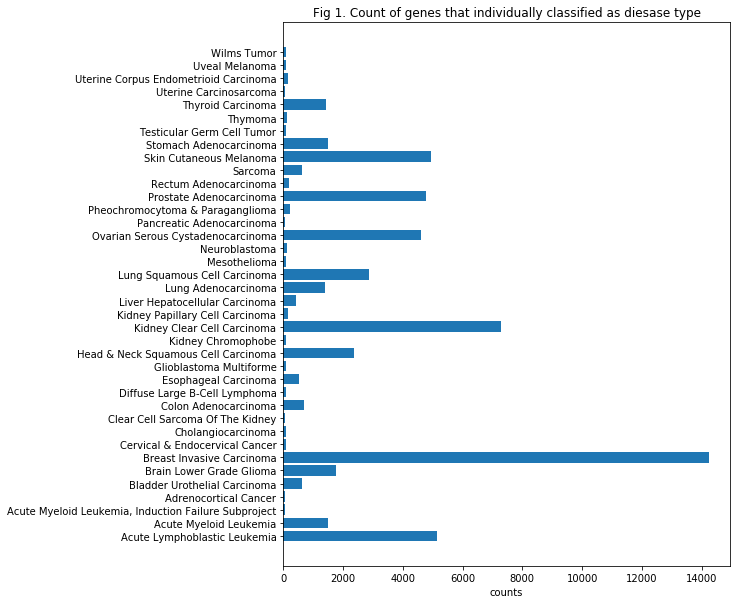

In [9]:
%%capture --no-display
# turn off deprecation warnings
# https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=capture#cellmagic-capture

fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
countsList = [v[0][0] for v in countsDict.values()]
# AEDWIP no magic number 38 = number of classes
dt = diseaseLabelEncoder.inverse_transform(range(38))
plt.barh(dt, countsList)
plt.title("Fig 1. Count of genes that individually classified as diesase type")
plt.xlabel("counts")
plt.savefig('images/diseaseTypeClassifierEvalFig1.png')

plt.show()

In [10]:
# find disease with fewest genes that individually classified as diesase type
# this is ugly. could not figure out how to do this using pandas
from math import inf
smallest = (inf, "AEDWIP")
for k, vv in countsDict.items():
    v = vv[0][0]
    if smallest[0] > v:
        smallest = (v, k)

print(smallest)

(44, "24_['Pancreatic Adenocarcinoma']")


In [11]:
#https://www.tutorialspoint.com/python_pandas/python_pandas_groupby.htm
groupedDF = activationDF.groupby('disease')
#groupedDF.get_group('Pancreatic Adenocarcinoma')

In [12]:
setCount = smallest[0]
smallestDiseaseValue, smallestDisease = smallest[1].split("_")
print("disease type with smallest identified gene set:{}".format(smallestDisease))
print("number of genes in set:{}".format(setCount))
groupedDF.get_group('Pancreatic Adenocarcinoma')['HugoId'].values

disease type with smallest identified gene set:['Pancreatic Adenocarcinoma']
number of genes in set:44


array(['AC079235.1', 'AC087499.9', 'AC090311.1', 'AC231645.1',
       'AL008708.1', 'AL354931.1', 'AL603650.4', 'ARAF', 'ATP6V1D',
       'C14orf93', 'CLK3', 'CNPY3', 'CTC-258N23.3', 'CTD-2132H18.3',
       'CYB5D2', 'FADS2P1', 'FBXW4', 'GOLGB1', 'HMGN1P5', 'KB-1582A10.2',
       'LINC00616', 'LINC01035', 'MED10', 'MON1A', 'NEK3', 'PIN1',
       'RFPL3-AS1_1', 'RNA5SP143', 'RNA5SP366', 'RNA5SP409', 'RNA5SP523',
       'RNA5SP55', 'RNU6-1194P', 'RNU6-204P', 'RNU6-498P',
       'RP11-626I20.3', 'RP11-74J13.9', 'SCARNA4', 'SF3B5', 'SGSM3',
       'SLC35B3', 'SNORA70D', 'STX18', 'SUGT1'], dtype=object)

https://www.kegg.jp/kegg-bin/search?q=%09Pancreatic+Adenocarcinoma&display=disease&from=disease
https://www.kegg.jp/dbget-bin/www_bget?ds:H00019

        
google CYB5D2 Pancreatic Adenocarcinoma
https://www.proteinatlas.org/ENSG00000167740-CYB5D2/pathology
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4753160/